# Random Count Generator

# 1)

Create a function that prints a random number between 1 and 5 to stdout (or console). The probability distribution of the numbers should be as follows:

* 1 - 50%
* 2 - 25%
* 3 - 15%
* 4 - 5%
* 5 - 5%

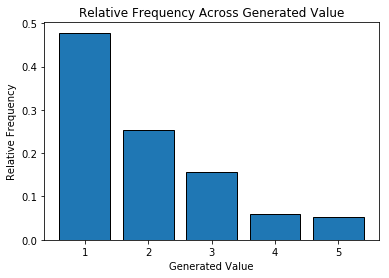

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter


def generate_number(X=[1, 2, 3, 4, 5], 
                    P_X=[0.5, 0.25, 0.15, 0.05, 0.05]):   
    return np.random.choice(X, p=P_X)

num = 1000
counter = Counter(generate_number() for _ in range(num))
x_axis = sorted(counter)
y_axis = [counter[val] / num for val in x_axis]

plt.bar(x_axis, y_axis, edgecolor='black')
plt.title('Relative Frequency Across Generated Value')
plt.xlabel('Generated Value')
plt.ylabel('Relative Frequency')

# 2)  
Change the function to a method, add a class member that stores a history of the last 100 numbers, and a function to return the frequency percentages of each number.

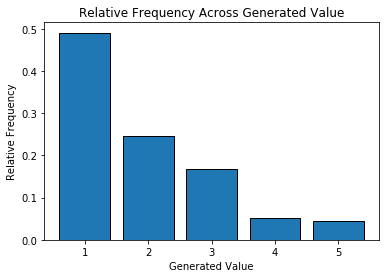

[(1, 0.44), (2, 0.29), (3, 0.15), (4, 0.07), (5, 0.05)]


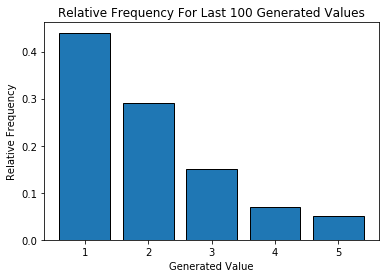

In [2]:
from collections import Counter, deque

class Random_Count_Generator_v0(object):
    def __init__(self, 
                 X=[1, 2, 3, 4, 5], 
                 P_X=[0.5, 0.25, 0.15, 0.05, 0.05],
                 max_history_length=100):
        self.X = X
        self.P_X = P_X
        self.recent_history = deque(maxlen=max_history_length)
        self.history_counter = Counter()
        self.max_history_length=max_history_length
        
    def generate_number(self):
        new_value = np.random.choice(self.X, p=self.P_X)
        if len(self.recent_history) == self.max_history_length:
            forgotten_value = self.recent_history.popleft()
            self.history_counter[forgotten_value] -= 1        
        self.recent_history.append(new_value)
        self.history_counter[new_value] += 1
        return new_value
            
    def get_relative_frequency_of_recent_history(self):
        current_length = len(self.recent_history)
        relative_frequency = [(val, count / current_length) for 
                              val, count in self.history_counter.items()]
        return sorted(relative_frequency, key=lambda tup: tup[0])

num = 1000
rcg = Random_Count_Generator_v0()
counter = Counter(rcg.generate_number() for _ in range(num))
x_axis = sorted(counter)
y_axis = [counter[val] / num for val in x_axis]

plt.bar(x_axis, y_axis, edgecolor='black')
plt.title('Relative Frequency Across Generated Value')
plt.xlabel('Generated Value')
plt.ylabel('Relative Frequency')
plt.show()

relative_frequency_of_recent_history = rcg.get_relative_frequency_of_recent_history()
print(relative_frequency_of_recent_history)
plt.bar(*(zip(*relative_frequency_of_recent_history)), edgecolor='black')
plt.title('Relative Frequency For Last 100 Generated Values')
plt.xlabel('Generated Value')
plt.ylabel('Relative Frequency')
plt.show()

# 3)
Create a method that reads the most recently generated random number and the current time and writes them both to disk on one line.

In [3]:
from datetime import datetime

class Random_Count_Generator_v1(Random_Count_Generator_v0):
    def __init__(self, 
                 X=[1, 2, 3, 4, 5], 
                 P_X=[0.5, 0.25, 0.15, 0.05, 0.05],
                 max_history_length=100):
        Random_Count_Generator_v0.__init__(self, X, P_X, max_history_length)
        
    def write_most_recent_value(self, output_file_name):
        with open(output_file_name, mode='a') as f:
            f.write(str(self.recent_history[-1]) + '\t' + str(datetime.now()) + '\n')

            
rcg = Random_Count_Generator_v1()
output_file = 'most_recent_results.txt'
!rm {output_file}
for _ in range(10):
    rcg.generate_number()
    rcg.write_most_recent_value(output_file)

In [4]:
!cat {output_file}

2	2017-12-15 19:20:20.360373
2	2017-12-15 19:20:20.361376
2	2017-12-15 19:20:20.362380
1	2017-12-15 19:20:20.363228
2	2017-12-15 19:20:20.364636
4	2017-12-15 19:20:20.365664
2	2017-12-15 19:20:20.366667
2	2017-12-15 19:20:20.367668
1	2017-12-15 19:20:20.369206
3	2017-12-15 19:20:20.369206


# 4)
Modify the writer function so it is launched in a different thread. The random number generator should put the numbers and timestamps into a queue that the writer function uses to write its output to disk.

In [5]:
from threading import Thread
from collections import defaultdict
import time


class Random_Count_Generator_v2(Random_Count_Generator_v1):
    def __init__(self, 
                 X=[1, 2, 3, 4, 5], 
                 P_X=[0.5, 0.25, 0.15, 0.05, 0.05],
                 max_history_length=100):
        Random_Count_Generator_v1.__init__(self, X, P_X, max_history_length)
        self.entire_history = deque()
        self.still_generating_numbers = False

    def generator_inside_thread(self, arrival_rate=10, seconds_until_shutdown=None):
        seconds_until_shutdown = seconds_until_shutdown if \
            seconds_until_shutdown else float('inf')
        start_time = time.time()

        while time.time() - start_time < seconds_until_shutdown:
            time.sleep(np.random.exponential(1 / arrival_rate))
            current_val = self.generate_number()
            self.entire_history.append((datetime.now(), current_val))            
        
    def writer(self, output_file_name):
        while self.still_generating_numbers:
            try:
                generated_date, generated_val = self.entire_history.popleft()
            except IndexError:
                time.sleep(0.2) # reduce CPU usage when queue is empty
                continue
            with open(output_file_name, mode='a') as f:
                f.write(str(generated_date) + '\t' + str(generated_val) + '\n')        
            
    def run_threads(self, output_file_name, arrival_rate=10, seconds_until_shutdown=None):
        self.still_generating_numbers = True
        g = Thread(target=self.generator_inside_thread, 
                   args=(arrival_rate, seconds_until_shutdown))
        g.start()
                
        w = Thread(target=self.writer, args=(output_file_name,)) # 
        w.start()
        
        g.join() # ensure number generators terminate, not blocking
        
        while self.entire_history: # 
            time.sleep(0.2) # allow more time for writer() to empty the queues
            
        self.still_generating_numbers = False # switch to turn off, tells writer() to terminate 
        w.join() # ensure writer finishes running prior to exiting out of method

In [6]:
%%time
rcg = Random_Count_Generator_v2()
output_file_name = 'most_recent_results.txt'
!rm {output_file_name}

rcg.run_threads(output_file_name, arrival_rate=10, seconds_until_shutdown=5)

Wall time: 5.5 s


In [7]:
!wc -l {output_file_name}
!head {output_file_name}

56 most_recent_results.txt
2017-12-15 19:20:20.836629	1
2017-12-15 19:20:20.855105	2
2017-12-15 19:20:20.890832	1
2017-12-15 19:20:20.924539	1
2017-12-15 19:20:20.938093	2
2017-12-15 19:20:21.045093	1
2017-12-15 19:20:21.178991	1
2017-12-15 19:20:21.233306	2
2017-12-15 19:20:21.406247	1
2017-12-15 19:20:21.417870	2


# 5)
Modify the program so it has 5 copies of the random number function running concurrently in different threads. They should all feed the single writer thread counts and timestamps, and the writer should ensure they are written in chronological order.

In [8]:
class Random_Count_Generator_v3(Random_Count_Generator_v2):
    def __init__(self, 
                 X=[1, 2, 3, 4, 5], 
                 P_X=[0.5, 0.25, 0.15, 0.05, 0.05],
                 max_history_length=100):
        Random_Count_Generator_v2.__init__(self, X, P_X, max_history_length)
        self.thread_histories = defaultdict(deque)
        self.threads = []
                
    def generator_inside_thread(self, thread_id, arrival_rate=10,  # method overridden
                                seconds_until_shutdown=None):
        seconds_until_shutdown = seconds_until_shutdown if seconds_until_shutdown else float('inf')
        start_time = time.time()

        while time.time() - start_time < seconds_until_shutdown:
            time.sleep(np.random.exponential(1 / arrival_rate))
            current_val = self.generate_number()
            self.thread_histories[thread_id].append((datetime.now(), current_val))
            
    def writer(self, output_file_name, num_threads): # method overridden
        earliest_numbers = {}
        while self.still_generating_numbers:
            for thread_id in range(num_threads):
                if not earliest_numbers.get(thread_id): # checks whether queue is empty
                    try: 
                        earliest_numbers[thread_id] = self.thread_histories[thread_id].popleft()
                    except IndexError:
                        pass

            existing_earliest_numbers = ([earliest_numbers[thread_id], thread_id] for thread_id
                 in earliest_numbers if earliest_numbers.get(thread_id))            
            existing_earliest_numbers = sorted(existing_earliest_numbers, key=lambda item: item[0][0])
            
            if not existing_earliest_numbers: # if all the queues are completely empty, 
                time.sleep(0.2) # wait a bit and then try again
                continue
            else:
                (generated_date, generated_val), thread_id_ = existing_earliest_numbers[0]
                with open(output_file_name, mode='a') as f:
                    f.write(str(generated_date) + '\t' + str(generated_val) + '\n')
                earliest_numbers.pop(thread_id_)
                
    def run_threads(self, output_file_name, num_threads, arrival_rate=10,  # method overridden
                    seconds_until_shutdown=None):
        self.still_generating_numbers = True
        for thread_id in range(num_threads):
            g = Thread(target=self.generator_inside_thread, 
                       args=(thread_id, arrival_rate, seconds_until_shutdown))
            g.start()
            self.threads.append(g)
                
        w = Thread(target=self.writer, args=(output_file_name, num_threads,))
        w.start()
        
        for g in self.threads:
            g.join() # ensure number generators terminate, not blocking
        
        while any(self.thread_histories.values()): # check if all histories are empty
            time.sleep(0.02) # allow more time for writer() to empty the queues
        
        self.still_generating_numbers = False  # switch to turn off, tells writer() to terminate
        w.join() # ensure writer finishes running prior to exiting out of method

In [9]:
%%time
rcg = Random_Count_Generator_v3()
output_file_name = 'most_recent_results.txt'
!rm {output_file_name}

rcg.run_threads(output_file_name=output_file_name, num_threads=5, 
                arrival_rate=10, seconds_until_shutdown=4)

Wall time: 4.98 s


In [10]:
!wc -l {output_file_name}
!head {output_file_name}

208 most_recent_results.txt
2017-12-15 19:20:26.662457	1
2017-12-15 19:20:26.698494	1
2017-12-15 19:20:26.698494	3
2017-12-15 19:20:26.715542	1
2017-12-15 19:20:26.770273	1
2017-12-15 19:20:26.787554	1
2017-12-15 19:20:26.841116	3
2017-12-15 19:20:26.841116	1
2017-12-15 19:20:26.874497	3
2017-12-15 19:20:26.879132	1


In [11]:
# Proof of Correctness--Sorted by datetimes correctly
with open('most_recent_results.txt') as f:
    date_times = []
    for line in f:
        date_times.append(datetime.strptime(line.split('\t')[0], 
                                            "%Y-%m-%d %H:%M:%S.%f"))
    print("In Sorted Order: {}".format(date_times == sorted(date_times)))

In Sorted Order: True
